# DeepLIIF Inference Request Demo
This notebook is inteded to show how to test the DeepLIIF deployment on WMLA in 2 ways:
- request with an image from the storage volume
- request with a serialized image in the payload

Additionally, it includes error handling tests as well.

In [1]:
import os
import wmla_edi_utils as edi
from PIL import Image
import requests

DEPLOYMENT_URL = "https://wmla-inference-cpd-wmla.apps.cpd.mskcc.org/dlim/v1/inference/deepliif-wendy-test-2"

## Image on volume (recommended for large images)

In [2]:
import uuid

In [3]:
request_id = str(uuid.uuid4())
request_id

'05905fac-126d-467c-9e5f-0ec43dd42bdf'

In [4]:
headers = {'Authorization': f'Bearer {os.getenv("USER_ACCESS_TOKEN")}'}
data = {
        'request_id': request_id,
        'img_path_on_pvc':'edi_deployments/sample_input_images/22_2_real_A.png',
        'tile_size': 512,
        'images_to_return': 'seg_masks',
        }

In [5]:
r = requests.post(DEPLOYMENT_URL, headers=headers,
                  json = data, verify = False)
r.status_code

200

In [6]:
r.json()

{'request_id': '05905fac-126d-467c-9e5f-0ec43dd42bdf',
 'log': [],
 'msg': '05905fac-126d-467c-9e5f-0ec43dd42bdf: Inference complete, output files can be found in edi_deployments/deepliif-wendy-test-2/output_dir/05905fac-126d-467c-9e5f-0ec43dd42bdf (storage volume AdditionalDeepLIIFVolume)'}

In [7]:
!ls -lh /mnts/AdditionalDeepLIIFVolume/edi_deployments/deepliif-wendy-test-2/output_dir/$request_id

total 672K
-rw-r--r--. 1 1000670000 root 335K May 11 16:24 22_2_real_A_SegOverlaid.png
-rw-r--r--. 1 1000670000 root 310K May 11 16:24 22_2_real_A_Seg.png
-rw-r--r--. 1 1000670000 root  21K May 11 16:24 22_2_real_A_SegRefined.png


## Send and return serialized image in request

In [8]:
local_image = Image.open("/mnts/DeepLIIFData/edi_deployments/sample_input_images/22_2_real_A.png")

In [9]:
headers = {'Authorization': f'Bearer {os.getenv("USER_ACCESS_TOKEN")}'}
data = {
        'local_input_image': edi.serialize_image(local_image),
        'tile_size': 512,
        'images_to_return': 'all',
        }

In [10]:
r2 = requests.post(DEPLOYMENT_URL, headers=headers,
                  json = data, verify = False)
r2.status_code

200

In [11]:
output = r2.json()
output.keys()

dict_keys(['request_id', 'log', 'msg', 'images'])

In [12]:
output['request_id'], output['log'], output['msg']

('f65fd479-b1ed-4349-a129-95f8bf6ca276',
 [],
 'f65fd479-b1ed-4349-a129-95f8bf6ca276: Inference complete, output images can be found in images field.')

In [13]:
output['images'].keys()

dict_keys(['local_DAPI.png', 'local_SegOverlaid.png', 'local_Hema.png', 'local_Marker.png', 'local_Seg.png', 'local_Lap2.png', 'local_SegRefined.png'])

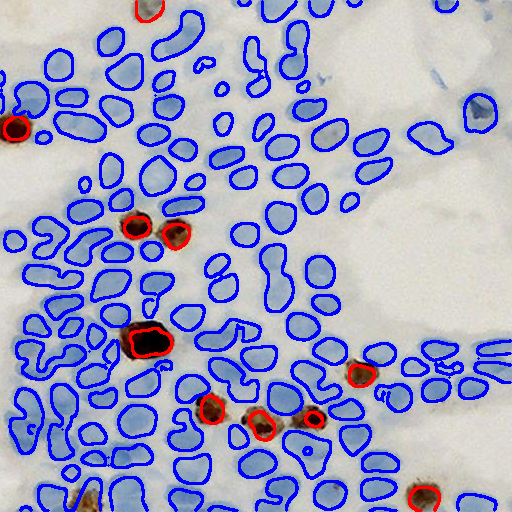

In [14]:
Image.open(edi.deserialize_image(output['images']['local_SegOverlaid.png']))

## Error Handling Test

In [15]:
headers = {'Authorization': f'Bearer {os.getenv("USER_ACCESS_TOKEN")}'}

local_image = Image.open("/mnts/DeepLIIFData/edi_deployments/sample_input_images/22_2_real_A.png")
data = {
        #'local_input_image': edi.serialize_image(local_image),
        'tile_size': 512,
        'images_to_return': 'all',
        }

r = requests.post(DEPLOYMENT_URL, headers=headers,
                  json = data, verify = False)

r.status_code, r.text

(200,
 '{"request_id": "8b9104b7-f2bb-4da4-82b4-20ec12e1868a", "log": [], "msg": "Error: no valid input image, provide either path_source or local_image"}')

In [16]:
headers = {'Authorization': f'Bearer {os.getenv("USER_ACCESS_TOKEN")}'}

local_image = Image.open("/mnts/DeepLIIFData/edi_deployments/sample_input_images/22_2_real_A.png")
data = {
        'local_input_image': edi.serialize_image(local_image),
        'tile_size': 512,
        'images_to_return': 'what',
        }

r = requests.post(DEPLOYMENT_URL, headers=headers,
                  json = data, verify = False)

r.status_code, r.text

(200,
 '{"request_id": "823418b6-302e-4953-a5f9-03e2a029db32", "log": [], "msg": "Error: images_to_return is not one of [\'all\', \'modalities\', \'seg_masks\']"}')

In [17]:
headers = {'Authorization': f'Bearer {os.getenv("USER_ACCESS_TOKEN")}'}

local_image = Image.open("/mnts/DeepLIIFData/edi_deployments/sample_input_images/22_2_real_A.png")
data = {
        'local_input_image': edi.serialize_image(local_image),
        'tile_size': 512.123,
        'images_to_return': 'what',
        }

r = requests.post(DEPLOYMENT_URL, headers=headers,
                  json = data, verify = False)

r.status_code, r.text

(200,
 '{"request_id": "a115b4b5-3914-48dc-a763-f2e29d4624de", "log": [], "msg": "Error: tile size is not integer"}')

In [18]:
headers = {'Authorization': f'Bearer {os.getenv("USER_ACCESS_TOKEN")}'}

local_image = Image.open("/mnts/DeepLIIFData/edi_deployments/sample_input_images/22_2_real_A.png")
data = {
        'local_input_image': edi.serialize_image(local_image),
        'tile_size': 0,
        'images_to_return': 'all',
        }

r = requests.post(DEPLOYMENT_URL, headers=headers,
                  json = data, verify = False)

r.status_code, r.text

(200,
 '{"request_id": "e270e362-e3b3-4fbf-bf24-500306d357fc", "log": ["CompletedProcess(args=\'python cli.py test --input-dir edi_deployments/deepliif-wendy-test-2/input_dir/ --output-dir edi_deployments/deepliif-wendy-test-2/output_dir/e270e362-e3b3-4fbf-bf24-500306d357fc --tile-size 0\', returncode=1, stdout=b\'\', stderr=b\'Traceback (most recent call last):\\\\n  File \\"cli.py\\", line 592, in <module>\\\\n    cli()\\\\n  File \\"/opt/anaconda3/envs/dlipy3/lib/python3.8/site-packages/click/core.py\\", line 829, in __call__\\\\n    return self.main(*args, **kwargs)\\\\n  File \\"/opt/anaconda3/envs/dlipy3/lib/python3.8/site-packages/click/core.py\\", line 782, in main\\\\n    rv = self.invoke(ctx)\\\\n  File \\"/opt/anaconda3/envs/dlipy3/lib/python3.8/site-packages/click/core.py\\", line 1259, in invoke\\\\n    return _process_result(sub_ctx.command.invoke(sub_ctx))\\\\n  File \\"/opt/anaconda3/envs/dlipy3/lib/python3.8/site-packages/click/core.py\\", line 1066, in invoke\\\\n    